In [20]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [21]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [22]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

In [23]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

STEPS
- get sequences (the same way we always do)
- remove all actions except C,P,$T_O$
- repeat analysis by group and time for seqs of lenths 2-10 (like last time)
- keep filter of 35% though prehaps we can increase it

OR, test frequency of all these seqs (6 combos):

* $T_1,T_2,T_M$ increasing complexity
* $T_1,T_M,T_2$ skipping compare and contrast
* $T_2,T_M,T_1$ back to basics
* $T_2,T_1,T_M$ back to basics then complex
* $T_M,T_1,T_2$ complex, then increasing
* $T_M,T_2,T_1$ decreasing in complextiy





### First we get the student groups and their sequences of actions

In [24]:
# students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
# LH = H_post.intersection(students_Lpre)
# LL = L_post.intersection(students_Lpre)
# print "There are {0} low pre students, of which {1} are low to high learners and {2} low to low learners.".format(len(students_Lpre),len(LH),len(LL))

In [25]:
# #get all action blocks in one long string per students for LL and LH groups.
# blocksLH, _ = get_blocks_withTime_new(df, LH, 'Family', as_list = True, ignore = ['I'], start = False)
# blocksLL, _ = get_blocks_withTime_new(df, LL, 'Family', as_list = True, ignore = ['I'], start = False)

### Now we are only interested in testing actions so we remove the rest
For now we don't do anything ig Test other and leave them there.

In [26]:
def keep_tests(k,seq):
    seq = [c for c in seq if c not in ['C','P']]
    return seq
blocks, timecoords = get_blocks_withTime_new(df, get_students('split pre','low'), 'Family', as_list = True, ignore = ['I'], start = False)
newblocks = {k:keep_tests(k,v) for k,v in blocks.iteritems()}

### Next we run the info gain analysis

In [27]:
def get_blocks_withTime_new(df, students, category_column, as_list = True, ignore = [], start = False, remove_actions = []):
    '''gets blocks of sequences for a list of students
    From the column "Family", "Family_tool", "Family_default" or "Family_both" in the dataframe, each action family is converted to a string in
    the format with at least one capitalized character: 'C', or 'Cccc'.
    To facilitate sequence mining. The sequence is exported as a list:
    ['Ta', 'C','Tb',.....].
    
    Arguments:
        students: list with student ids to generate blocks for
        category_column: the column of the dataframe from which cetagories are taken from
        as_list: by default true. returns sequences as a list of strings instead of a single string
        ignore: list of actions to ignore
        start: if we want a start action to find the first sequence of action of every student   
    
    returns:
     blocks = {student_1_id: ['Ta', 'C','Tb',.....], student_2_id: [...]}    
     time_coords = {student_1_id: [(start_of_action_1, duration), (start_of_action_2, duration),...], student_2_id: [...]}    
    '''
    def convert(action):
        return converter[action]
    
    if start:
        blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}

    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df[df['student']==student][category_column])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator
        previous_end = 0
        for match in p.finditer(''.join([convert(action) for action in sequence if convert(action) not in ignore])):
            ind = match.span()  #this gives start and end of matched block
            #for matches of action denoted by more than 1 letter, need to correct the span
            ind = (previous_end, previous_end + (ind[1]-ind[0])/len(set(match.group())))
            #save the end time of one action as the start action of the next
            previous_end = ind[1]
            #print match.group(), ind
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([convert(action) for action in sequence if convert(action) not in ignore]))
        list_block = block[0] + ''.join([' ' + c if c.isupper() else c for c in block[1:]])
        list_block = list_block.split(' ')
        if remove_actions:
            for action_to_remove in remove_actions:
                indices = [i for i, x in enumerate(list_block) if x == action_to_remove]
                list_block = [a for i,a in enumerate(list_block) if i not in indices]
                time_coord = [a for i,a in enumerate(time_coord) if i not in indices]
        if as_list:
            blocks[student] = list_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords


In [43]:
def get_frequencies_by_bin(blocks, students, time_coords, B,shortest=3, longest=11):
    '''
    Given blocks of actions and a range of sequence lengths, we can find the frequency of sequence
    use within each bin.
    
    Arguments:
        blocks: blocked sequences for each student
        action_bins
        shortest: length of shortest possible mined sequence
        longest: length of longest possible mined sequence
        
    returns:
        frequencies = {student: [list of Counters for each bin]}
                    = {student1: [ Counter{'TPT':3, 'CPT':5...}, Counter{},... ],  ...}
    '''
    action_bins = get_bins_per_student(students, time_coords,B)
    frequencies = {student:[Counter() for i in range(B)] for student in blocks.keys()}        
    for student,sequence in blocks.iteritems():
        for seq_length in range(shortest, longest+1):  # loops through different possible sequence lengths
            for j,(start_action,end_action) in enumerate(action_bins[student]): 
                if start_action == None: start_action = 0
                if end_action == None: end_action = seq_length
                #since we want to find sequence THAT START in bin, we remove the parts of the sequence that fall in previous bins
                portion_of_sequence = sequence[start_action:end_action+seq_length-1]
                frequencies[student][j] += Counter(''.join(portion_of_sequence[i:i+seq_length]) for i in range(end_action-start_action))  # counts string matches for every string of the current length
    return frequencies

In [48]:
def get_sequence_use_by_timebin(df, students, category_column, B, attribute, level1, level2, shortest_seq_length, longest_seq_length, cut_off,remove_actions = []):
    '''
    '''
    
    print """Getting sequence use over {3} time bins for {0} students split by {1}. 
    Keeping only sequences used once by at least {2}% of students 
    in each group and overall.""".format(len(students),attribute,int(cut_off*100),B)

    #get all seqs per student per time bin        
    blocks, time_coords =  get_blocks_withTime_new(df, students, category_column, start=False, ignore = ['I'], remove_actions = remove_actions)
    frequencies_by_bin = get_frequencies_by_bin(blocks, students, time_coords, B, shortest = shortest_seq_length, longest = longest_seq_length)

    cleaned_frequencies = Counter()
    for attr,level in [(attribute,level1),(attribute,level2)]:
        students_in_group = get_students(attr,level)
        N = int(cut_off*len(students_in_group))
        blocks, time_coords =  get_blocks_withTime_new(df, students_in_group, category_column, start=False, ignore = ['I'], remove_actions = remove_actions)
        #find all sequences to consider for analysis, given that they have been used by enough students
        frequencies = get_frequencies(blocks, shortest = shortest_seq_length, longest = longest_seq_length)
        counts_frequencies = Counter({f:sum([ 1 if f in freq else 0 for freq in frequencies.values()]) for f in list(sum(frequencies.values(),Counter()))})
        cleaned_frequencies += remove_rare_frequencies(counts_frequencies, N)    
    
    counts = count_use_per_group_per_bin(cleaned_frequencies, frequencies_by_bin, B, attribute, level1, level2)
    return counts

For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
For attribute split post t2, categories Family
Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


C:\Users\Sarah\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


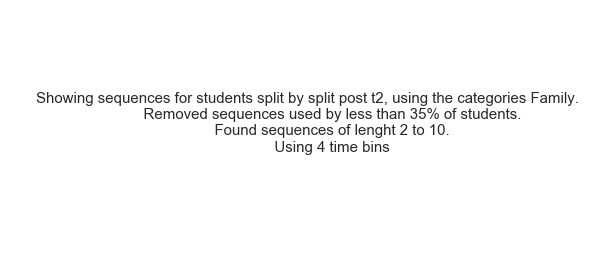

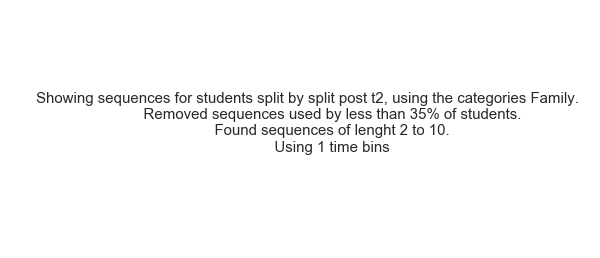

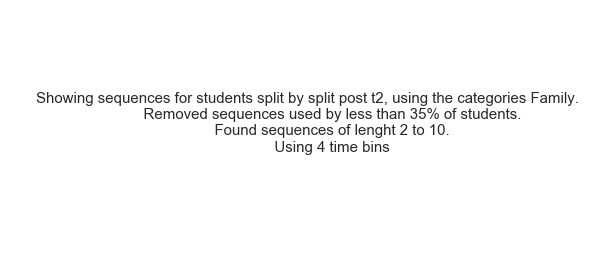

In [51]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10
BINS = 4  #number of bins

### PARAMETERS
attributes = [('split post t2','high','low')]
family_categories = ["Family"]#,"Family_tool","Family_default"]

parse_axis = {0:'time',1:'group',None:'time and group'}
pdf = PdfPages('infogain_results_by_post2_testing_seqs.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        for axis in [0,1,None]:
            if axis == 1: B = 1
            else: B = BINS
        
            print "For attribute {0}, categories {1}".format(attribute,family_category)
            pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
            sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF,remove_actions= ['C','P'])
            ylabels = [level1,level2]
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),15)
#             print parse_axis[axis]
            for seq,infogain in tops:
#                 print seq, infogain
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()